In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from arch import arch_model

import sys

import yfinance as yf
import os

In [2]:
from lab13_helpers import *

In [3]:
# Download AORD data
name_ao = 'ao_yf_2009_2021.csv'
if not os.path.isfile(name_ao):
    data_ao = yf.download("^AORD", start='2009-01-01', end='2021-10-23')
    data_ao.to_csv(name_ao)

data_ao = pd.read_csv(name_ao, index_col='Date', parse_dates=True, dayfirst=True)
r_ao = 100 * np.log(data_ao['Adj Close']).diff().dropna()

In [4]:
# Last day of in-sample period
last_in = '2017-11-09'
# First day of forecasting period
frst_fc = '2017-11-10'

In [5]:
n_fore = len(r_ao[frst_fc:])
n_wind = len(r_ao[:last_in])

## Q2
Now we will use the SP500 lagged return as an exogenous regressor in the GJR-t model to see if this improves performance in any way.

In [6]:
name_us = 'us_yf_2009_2021.csv'
if not os.path.isfile(name_us):
    data_us = yf.download("^GSPC", start='2009-01-01', end='2021-10-23')
    data_us.to_csv(name_us)

data_us = pd.read_csv(name_us, index_col='Date', parse_dates=True, dayfirst=True)
r_us = 100 * np.log(data_us['Adj Close']).diff().dropna()

In [7]:
# Synchronise by date
date_common = data_us.index.intersection(data_ao.index)

p_us = data_us.loc[date_common, 'Adj Close']
p_ao = data_ao.loc[date_common, 'Adj Close']

r_us = 100 * np.log(p_us).diff().dropna()
r_ao = 100 * np.log(p_ao).diff().dropna()

In [8]:
# Last day of in-sample period
last_in = '2017-10-05'

# First day of forecasting period
frst_fc = '2017-10-06'

#### (a) Fit the Reg-GJR-GARCH(1,1)-t model to the AORD returns in the in-sample period, using the SP500 returns as a lag-1 regressor variable. Write down and interpret the estimated model


In [9]:
reg_gjgarcht_ao = arch_model(r_ao[:'2017-10-05'][1:], mean='ARX', lags=0, 
                             x=r_us[:'2017-10-04'], vol='GARCH', p=1, q=1, o=1, dist='StudentsT')

reg_gjgarcht_ao_fit = reg_gjgarcht_ao.fit(disp='off')
print(reg_gjgarcht_ao_fit.summary())

                           AR-X - GJR-GARCH Model Results                           
Dep. Variable:                    Adj Close   R-squared:                       0.281
Mean Model:                            AR-X   Adj. R-squared:                  0.281
Vol Model:                        GJR-GARCH   Log-Likelihood:               -2379.70
Distribution:      Standardized Student's t   AIC:                           4773.40
Method:                  Maximum Likelihood   BIC:                           4813.13
                                              No. Observations:                 2155
Date:                      Fri, Nov 12 2021   Df Residuals:                     2153
Time:                              11:23:12   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
C

### Answer guide
The estimated model is:

$r_t = -0.011 + 0.509 SP500_{t-1} + a_t$,   where $a_t = \sigma_t \varepsilon_t$ and where

$$
\sigma_t^2 = 0.018 + (0.030 + 0.129 I_{t-1}) a_{t-1}^2 + 0.877 \sigma_{t-1}^2
$$

where $\varepsilon_t \sim t^*_{14.5} (0,1)$ is a Student-t distribution standardised to have variance 1. 

The model says that the AORD index percentage log-return on day t can be estimated by -0.011 plus 50.9% of yesterdays US SP500 index percentage log-return; i.e. if the SP500 goes up by 1% yesterday, the AORD is predicted to go up by 0.5% today. 

The variance of the AORD index percentage log-return on day t can be estimated by 0.018 plus, on days when yesterday's return shock is positive, 0.030 times yesterday's return shock squared, or on days when yesterday's return shock is negative, 0.159 times yesterday's return shock squared, plus 0.877 times yesterday's estimated variance.   

#### (b) Calculate 2.5% and 1% ES forecasts for each day of the forecast period, for the models Reg-GJR-t, GJR-t and HS-100. Plot the forecasts and the ES residuals for each.

In [10]:
n_fore = len(r_ao[frst_fc:])
n_wind = len(r_ao[:last_in])

var25_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

es25_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es1_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

s_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

df_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

gjr_t = arch_model(r_ao, mean='Constant', vol='GARCH', p=1, o=1, q=1, dist='StudentsT')

for i in tqdm(range(n_fore)):
    if i % 20 == 0:
        gjr_t_fit = gjr_t.fit(first_obs=i, last_obs=i + n_wind, disp="off")

        fc = gjr_t_fit.forecast(horizon=1, align='target', reindex=False)
        temp25 = fc.mean + np.sqrt(fc.variance) * qt(0.025, gjr_t_fit.params['nu'])
        temp1 = fc.mean + np.sqrt(fc.variance) * qt(0.01, gjr_t_fit.params['nu'])
        
        s = np.sqrt(fc.variance)
        es25 = fc.mean + s * est(0.025, gjr_t_fit.params['nu'])
        es1 = fc.mean + s * est(0.01, gjr_t_fit.params['nu'])
        
    
    var25_gjr_t[i] = temp25.loc[var25_gjr_t.index[i]]
    var1_gjr_t[i] = temp1.loc[var1_gjr_t.index[i]]
    
    es25_gjr_t[i] = es25.loc[es25_gjr_t.index[i]]
    es1_gjr_t[i] = es1.loc[es1_gjr_t.index[i]]
    
    s_gjr_t[i] = s.loc[s_gjr_t.index[i]]
    
    df_gjr_t[i] = gjr_t_fit.params['nu']

  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
# The tutorials implementation for gjr-garch
y = r_ao[1:]
x = r_us[:-1]

n_fore = len(r_ao[frst_fc:])
n_wind = len(y) -  n_fore

var25_gjr_t2 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_gjr_t2 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

es25_gjr_t2 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es1_gjr_t2 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

s_gjr_t2 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

df_gjr_t2 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

gjr_t = arch_model(y, mean='Constant', vol='GARCH', p=1, o=1, q=1, dist='StudentsT')

for i in tqdm(range(n_fore)):
    y_is = y[i: i+n_wind]
    x_is = x[i: i+n_wind]
    gjr_t = arch_model(y_is, mean='Constant', vol='GARCH', p=1, q=1, o=1, dist='StudentsT')

    if i % 20 == 0:
        gjr_t_fit = gjr_t.fit( disp = "off" )
    
        # GJR-GARCH-t
        fc = gjr_t_fit.forecast(horizon=1, reindex=False)
        temp25 = fc.mean + np.sqrt(fc.variance) * qt(0.025, gjr_t_fit.params['nu'])
        temp1 = fc.mean + np.sqrt(fc.variance) * qt(0.01, gjr_t_fit.params['nu'])

        s = np.sqrt(fc.variance)
        es25 = fc.mean + s * est(0.025, gjr_t_fit.params['nu'])
        es1 = fc.mean + s * est(0.01, gjr_t_fit.params['nu'])
        
    
    var25_gjr_t2[i] = temp25.values #.loc[var25_gjr_t2.index[i]]
    var1_gjr_t2[i] = temp1.values #.loc[var1_gjr_t2.index[i]]
    
    
    es25_gjr_t2[i] = es25.values #.loc[es25_gjr_t2.index[i]]
    es1_gjr_t2[i] = es1.values #.loc[es1_gjr_t2.index[i]]
    
    s_gjr_t2[i] = s.values #.loc[s_gjr_t2.index[i]]
    
    df_gjr_t2[i] = gjr_t_fit.params['nu'] 

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
var25_hs100 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_hs100 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

es25_hs100 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es1_hs100 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

s_hs100 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

y = r_ao[1:]
x = r_us[:-1]

n_fore = len(r_ao[frst_fc:])
n_wind = len(y) -  n_fore
for i in tqdm(range(n_fore)):
    var25_hs100[i] = r_ao[(i + n_wind - 100):(i + n_wind)].quantile(0.025)
    var1_hs100[i] = r_ao[(i + n_wind - 100):(i + n_wind)].quantile(0.01)
    
    es25_hs100[i] = es(r_ao[(i + n_wind - 100):(i + n_wind)], 0.025)
    es1_hs100[i] = es(r_ao[(i + n_wind - 100):(i + n_wind)], 0.01)
    
    s_hs100[i] = r_ao[(i + n_wind - 100):(i + n_wind)].std()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
var25_reg_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_reg_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

es25_reg_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es1_reg_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

s_reg_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

df_reg_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

y = r_ao[1:]
x = r_us[:-1]

n_fore = len(r_ao[frst_fc:])
n_wind = len(y) -  n_fore
for i in tqdm(range(n_fore)):
    y_is = y[i: i+n_wind]
    x_is = x[i: i+n_wind]

    if i % 20 == 0:
        reg_gjr_t = arch_model(y_is, mean='ARX', lags=0, x=x_is, 
                               vol='GARCH', p=1, q=1, o=1, dist='StudentsT')
        
        reg_gjr_t_fit = reg_gjr_t.fit( disp = "off" )
       
    xnew = x[i+n_wind:i+n_wind+1]
    fc = reg_gjr_t_fit.forecast(horizon=1, reindex=False, x=xnew)
    
    temp25 = fc.mean + np.sqrt(fc.variance) * qt(0.025, reg_gjr_t_fit.params['nu'])
    temp1 = fc.mean + np.sqrt(fc.variance) * qt(0.01, reg_gjr_t_fit.params['nu'])
    
    var25_reg_gjr_t[i] = temp25.values  #loc[var25_reg_gjr_t.index[i]]
    var1_reg_gjr_t[i] = temp1.values    #.loc[var1_reg_gjr_t.index[i]]
      
    
    s = np.sqrt(fc.variance)
    
    es25 = fc.mean + s * est(0.025, reg_gjr_t_fit.params['nu'])
    es1 = fc.mean + s * est(0.01, reg_gjr_t_fit.params['nu'])
    
    es25_reg_gjr_t[i] = es25.values #.loc[es25_reg_gjr_t.index[i]]
    es1_reg_gjr_t[i] = es1.values #.loc[es1_reg_gjr_t.index[i]]
    
    s_reg_gjr_t[i] = s.values  #.loc[s_reg_gjr_t.index[i]]
    
    df_reg_gjr_t[i] = reg_gjr_t_fit.params['nu']
    
    if var25_reg_gjr_t[i] > 0:
        var25_reg_gjr_t[i] = var25_reg_gjr_t[i-1]
        es25_reg_gjr_t[i] = es25_reg_gjr_t[i-1]
        
        var1_reg_gjr_t[i] = var1_reg_gjr_t[i-1]
        es1_reg_gjr_t[i] = es1_reg_gjr_t[i-1]
        
        s_reg_gjr_t[i] = s_reg_gjr_t[i-1]

  0%|          | 0/1000 [00:00<?, ?it/s]

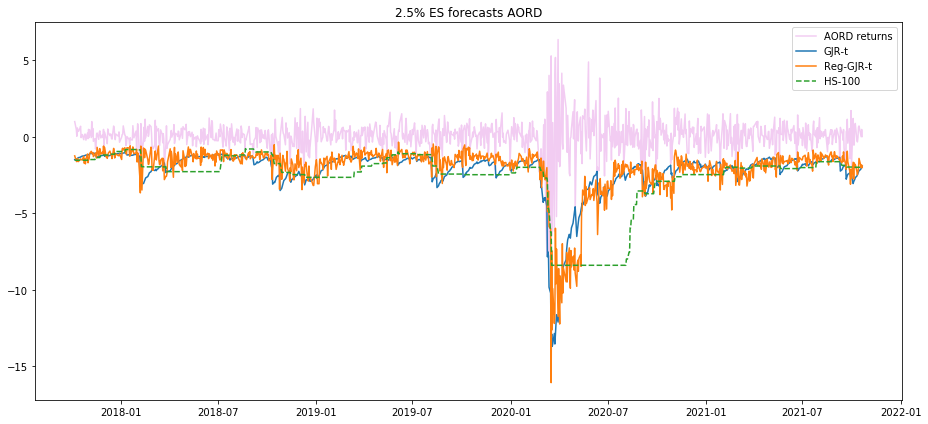

In [40]:
# Plot ES forecasts 2.5%
plt.figure(figsize=(13, 6))
plt.plot(r_ao[frst_fc:], 'm-', alpha=0.2, label='AORD returns')
plt.plot(es25_gjr_t, '-', label='GJR-t')
plt.plot(es25_reg_gjr_t, '-', label='Reg-GJR-t')
plt.plot(es25_hs100, '--', label='HS-100')
plt.title('2.5% ES forecasts AORD')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# ES residuals and scaled ES residuals
xi25_gjr_t, xis25_gjr_t = es_resid(es25_gjr_t, var25_gjr_t, s_gjr_t, r_ao[frst_fc:])
xi1_gjr_t, xis1_gjr_t = es_resid(es1_gjr_t, var1_gjr_t, s_gjr_t, r_ao[frst_fc:])

xi25_reg_gjr_t, xis25_reg_gjr_t = es_resid(es25_reg_gjr_t, var25_reg_gjr_t, s_reg_gjr_t, r_ao[frst_fc:])
xi1_reg_gjr_t, xis1_reg_gjr_t = es_resid(es1_reg_gjr_t, var1_reg_gjr_t, s_reg_gjr_t, r_ao[frst_fc:])

xi25_hs100, xis25_hs100 = es_resid(es25_hs100, var25_hs100, s_hs100, r_ao[frst_fc:])
xi1_hs100, xis1_hs100 = es_resid(es1_hs100, var1_hs100, s_hs100, r_ao[frst_fc:])

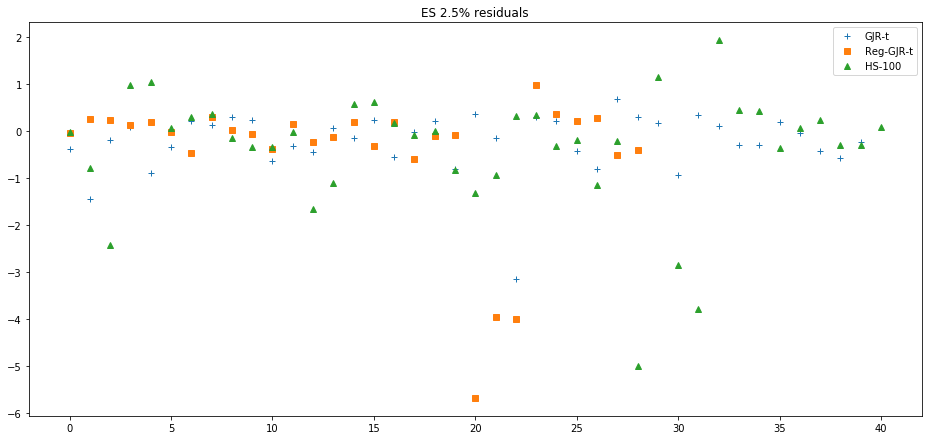

In [17]:
# Plot 2.5% ES residuals
plt.figure(figsize=(13, 6))
plt.plot(xi25_gjr_t.values, '+', label='GJR-t')
plt.plot(xi25_reg_gjr_t.values, 's', label='Reg-GJR-t')
plt.plot(xi25_hs100.values, '^', label='HS-100')
plt.legend()
plt.tight_layout()
plt.title('ES 2.5% residuals')
plt.show()

### Answer guide
The Reg-GJR-t model, using SP500 returns as a mean equation regressor, gives 2.5% ES forecasts that seem more variable than those from other GARCH models. This is due to the effect of the regressor: i.e. the AORD mean gets 50% of the daily returns on SP500; thus the mean AORD return is quite changeable from day to day. NOte that the volatility persistence here is 0.877 + 0.5 0.159 + 0.03 \approx 0.98$, which is still very high. Thus, low persistence does not explain the higher day-day variation in this model's ES forecasts, compared to usual GARCH models. The model's ES forecasts mostly follow the pattern of the GJR-t model's closely, but with more day-day variation.

The ES residuals for the Reg-GJR-t model seems slightly less variable than those for the GJR-t and HS100 models.

#### (c) Formally assess the accuracy of the 2.5% ES forecasts from the different models using the usual measures, i.e. mean residual, mean standardised residual with t-test, joint loss, RMSE and MAD statistics.

In [18]:
def check_es_fc_ex_10(es, var, s, r, p):
    hit = r < es
    n_hit = np.sum(hit)
    xi, xis = es_resid(es, var, s, r)
    rmse = np.sqrt(np.mean(xi ** 2))
    mad = np.mean(np.abs(xi))
    t_xi = ttest(xi, 0)[1]
    t_xis = ttest(xis, 0)[1]
    p_xis = ttest(xis, 0)[0]
    jl = jointloss(es, var, r, p)
    return [n_hit, np.mean(xi), t_xi, np.mean(xis), t_xis, p_xis, jl, rmse, mad]

In [19]:
# Table: 2.5% ES checks
tbl_es25_ex = pd.DataFrame({
    'GJR-t': check_es_fc_ex_10(es25_gjr_t, var25_gjr_t, s_gjr_t, r_ao[frst_fc:], 0.025),
    'Reg-GJR-t': check_es_fc_ex_10(es25_reg_gjr_t, var25_reg_gjr_t, s_reg_gjr_t, r_ao[frst_fc:], 0.025),
    'HS-100': check_es_fc_ex_10(es25_hs100, var25_hs100, s_hs100, r_ao[frst_fc:], 0.025)
    },
    index=['Viol. (10?)', 'Mean xi', 't xi', 'Mean xi/s', 't-stat', 'p-val', 'Joint loss', 'RMSE', 'MAD']
)
tbl_es25_ex.round(4)

,GJR-t,Reg-GJR-t,HS-100
Viol. (10?),23.0000,16.0000,23.0000
Mean xi,-0.2316,-0.4622,-0.3707
t xi,-2.2624,-1.6947,-1.8468
Mean xi/s,-0.2740,-0.7772,-0.5744
t-stat,-2.7281,-1.6152,-2.1869
p-val,0.0095,0.1175,0.0347
Joint loss,2.0241,1.8389,2.4360
RMSE,0.6799,1.5155,1.3225
MAD,0.4407,0.7043,0.8172


### Answer guide
The Reg-GJR-t model is easily closest to the expected 1% violation rate for 2.5% ES forecasts. It is the only model not giving significantly biased ES 2.5% forecasts too. It has lowest joint 2.5% VaR, ES forecast loss and lowest ES residual MAD, 2nd lowest RMSE. It is clearly the optimal ES 2.5% forecasting model of these 3 models. 

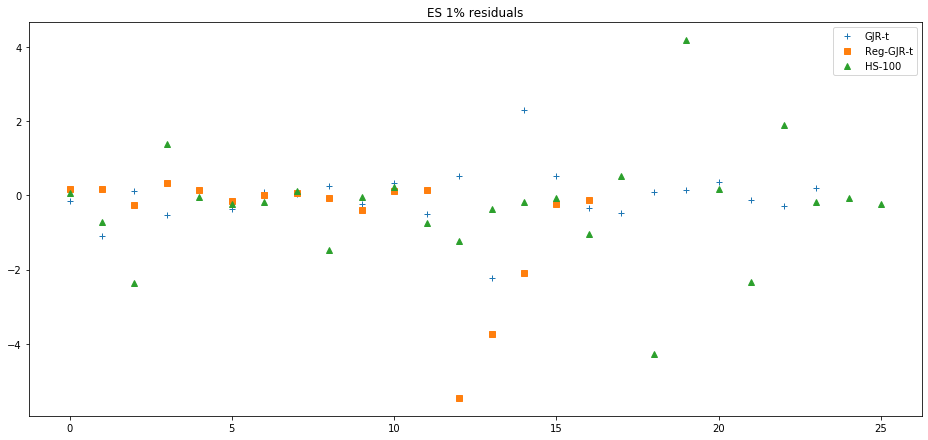

In [20]:
# Plot 1% ES residuals
plt.figure(figsize=(13, 6))
plt.plot(xi1_gjr_t.values, '+', label='GJR-t')
plt.plot(xi1_reg_gjr_t.values, 's', label='Reg-GJR-t')
plt.plot(xi1_hs100.values, '^', label='HS-100')
plt.legend()
plt.tight_layout()
plt.title('ES 1% residuals')
plt.show()

In [21]:
# Table: 1% ES checks
tbl_es1_ex = pd.DataFrame({
    'GJR-t': check_es_fc_ex_10(es1_gjr_t, var1_gjr_t, s_gjr_t, r_ao[frst_fc:], 0.01),
    'Reg-GJR-t': check_es_fc_ex_10(es1_reg_gjr_t, var1_reg_gjr_t, s_reg_gjr_t, r_ao[frst_fc:], 0.01),
    'HS-100': check_es_fc_ex_10(es1_hs100, var1_hs100, s_hs100, r_ao[frst_fc:], 0.01)
    },
    index=['Viol. (3?)', 'Mean xi', 't xi', 'Mean xi/s', 't-stat', 'p-val', 'Joint loss', 'RMSE', 'MAD']
)
tbl_es1_ex.round(4)

,GJR-t,Reg-GJR-t,HS-100
Viol. (3?),11.0000,10.0000,18.0000
Mean xi,-0.0507,-0.6689,-0.2773
t xi,-0.3242,-1.7209,-0.9379
Mean xi/s,-0.1500,-1.1483,-0.6142
t-stat,-1.3341,-1.4917,-1.6162
p-val,0.1952,0.1552,0.1186
Joint loss,2.2647,2.2302,3.0303
RMSE,0.7514,1.6925,1.5038
MAD,0.4740,0.8042,0.9359


In [44]:
len(es1_gjr_t) * 0.01

10.0

### Answer guide
The Reg-GJR-t model, has ES residuals that again seem slightly less variable than those for the GJR-t and HS100 models.

The Reg-GJR-t model is easily closest to the expected 0.3-0.4% violation rate for 1% ES forecasts (though it still seems better as a 1% VaR forecast). The Reg-GJR-t and HS100 are the only models not giving significantly biased ES 1% forecasts. The Reg-GJR-t has lowest joint 1% VaR, ES forecast loss and lowest ES residual MAD, 2nd lowest RMSE (1st is HS100). The Reg-GJR-t is clearly the optimal ES 1% forecasting model of these 3 models. 

#### (d) Assess the accuracy of the 2.5% and 1% VaR forecasts from these models. Compare the results to those obtained in Lab Tutorial 12 

In [22]:
# 2.5% VaR forecast accuracy checks
tbl_var25 = pd.DataFrame({
    'GJR-t': check_var_fc(var25_gjr_t, r_ao[frst_fc:], 0.025),
    'Reg-GJR-t': check_var_fc(var25_reg_gjr_t, r_ao[frst_fc:], 0.025),
    'HS100': check_var_fc(var25_hs100, r_ao[frst_fc:], 0.025)
    },
    index=['Viol. (25)', '$\hat{p}$', '$\hat{p}/p$', 'UC', 'Ind', 'DQ', 'Loss']
)
tbl_var25.round(4)

,GJR-t,Reg-GJR-t,HS100
Viol. (25),40.0000,29.0000,41.0000
$\hat{p}$,0.0400,0.0290,0.0410
$\hat{p}/p$,1.6000,1.1600,1.6400
UC,0.0024,0.4178,0.0012
Ind,0.3000,0.0086,0.0010
DQ,0.0142,0.0000,0.0000
Loss,74.4935,65.9072,94.6055


### Answer guide
The quantile loss function clearly and strongly favours the Reg-GJR-t model in forecasting 2.5% VaR, over the other two models. 
It is the only model with close to the expected VRate of 2.5%, with 2.9%, and is the only model not rejected for a VRate significantly different to 0.025. However, the Reg-GJR-t model fails the Ind and DQ tests (as do all models here), meaning its violations are correlated or clustered. The 2.5% violations plot below indicates some potential clustering in late 2018 and early 2020 as volatility rose and peaked, for the Reg-GJR-t model.

In [23]:
# 1% VaR forecast accuracy checks
tbl_var1 = pd.DataFrame({
    'GJR-t': check_var_fc(var1_gjr_t, r_ao[frst_fc:], 0.01),
    'Reg-GJR-t': check_var_fc(var1_reg_gjr_t, r_ao[frst_fc:], 0.01),
    'HS100': check_var_fc(var1_hs100, r_ao[frst_fc:], 0.01)
    },
    index=['Viol. (10)', '$\hat{p}$', '$\hat{p}/p$', 'UC', 'Ind', 'DQ', 'Loss']
)
tbl_var1.round(4)

,GJR-t,Reg-GJR-t,HS100
Viol. (10),24.0000,17.0000,26.000
$\hat{p}$,0.0240,0.0170,0.026
$\hat{p}/p$,2.4000,1.7000,2.600
UC,0.0000,0.0261,0.000
Ind,0.1288,0.2897,0.000
DQ,0.0000,0.0000,0.000
Loss,36.6292,37.5837,51.479


### Answer guide
The quantile loss function also clearly and strongly favours the Reg-GJR-t model in forecasting 1% VaR, over the other two models. It is the model with closest to the expected VRate of 1%, with 1.7%, however all models are rejected for a VRate significantly different to 0.01. Whilst the Reg-GJR-t model does not fail the Ind test, it is rejected by the DQ test (as are all models), meaning its violations are again correlated or clustered. The 1% violations plot below indicates some potential clustering in early 2020 as volatility rose and peaked, for the Reg-GJR-t model.

In [24]:
# Violations (hits)
hit25_gjr_t = r_ao[frst_fc:] < var25_gjr_t
hit1_gjr_t = r_ao[frst_fc:] < var1_gjr_t

hit25_reg_gjr_t = r_ao[frst_fc:] < var25_reg_gjr_t
hit1_reg_gjr_t = r_ao[frst_fc:] < var1_reg_gjr_t

hit25_hs100 = r_ao[frst_fc:] < var25_hs100
hit1_hs100 = r_ao[frst_fc:] < var1_hs100

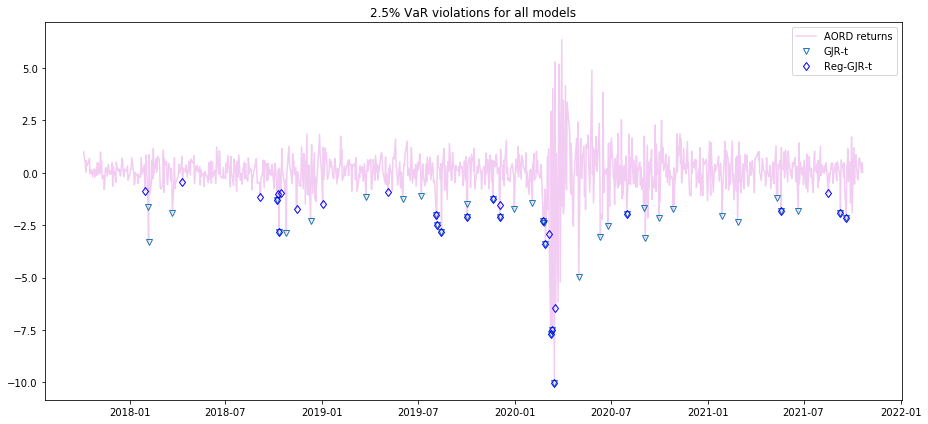

In [49]:
# 2.5% VaR violations
plt.figure(figsize=(13, 6))
plt.plot(r_ao[frst_fc:], '-m', alpha=0.2, label='AORD returns')
# plt.plot(r_ao[frst_fc:][hit25_hs100], 'o', mfc='none', label='HS-100')
plt.plot(r_ao[frst_fc:][hit25_gjr_t], 'v', mfc='none', label='GJR-t')
plt.plot(r_ao[frst_fc:][hit25_reg_gjr_t], 'db', mfc='none', label='Reg-GJR-t')
plt.title('2.5% VaR violations for all models')
plt.legend()
plt.tight_layout()
plt.show()

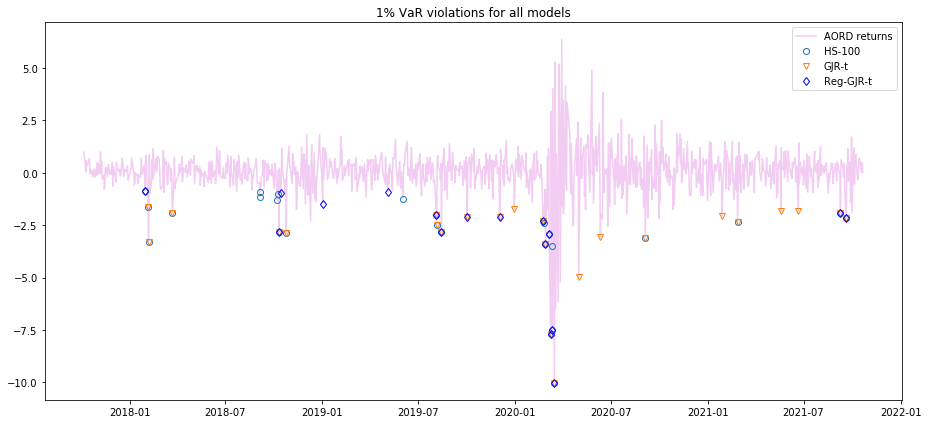

In [55]:
# 1% VaR violations
plt.figure(figsize=(13, 6))
plt.plot(r_ao[frst_fc:], '-m', alpha=0.2, label='AORD returns')
plt.plot(r_ao[frst_fc:][hit1_hs100], 'o', mfc='none', label='HS-100')
plt.plot(r_ao[frst_fc:][hit1_gjr_t], 'v', mfc='none', label='GJR-t')
plt.plot(r_ao[frst_fc:][hit1_reg_gjr_t], 'db', mfc='none', label='Reg-GJR-t')
plt.title('1% VaR violations for all models')
plt.legend()
plt.tight_layout()
plt.show()